In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
#импорт данных
data = pd.read_csv('C:/Users/kadyg/projects/finance/datas.csv')
keep_col = ['Date','Price']
data = data[keep_col]

In [57]:
data

,Date,Price
0,01/01/17,992.95
1,02/01/17,1011.45
2,03/01/17,1020.67
3,04/01/17,1130.30
4,05/01/17,1007.00
...,...,...
1893,13/03/22,37793.01
1894,14/03/22,39674.17
1895,15/03/22,39298.10
1896,16/03/22,41127.97


In [60]:
data.columns


Index(['Date', 'Price'], dtype='object')

In [61]:
#рассчет доходностей
data['r'] = data['Price'][1:].reset_index(drop=True)/data['Price'][:-1].reset_index(drop=True) - 1

In [62]:
data


,Date,Price,r
0,01/01/17,992.95,0.018631
1,02/01/17,1011.45,0.009116
2,03/01/17,1020.67,0.107410
3,04/01/17,1130.30,-0.109086
4,05/01/17,1007.00,-0.110516
...,...,...,...
1893,13/03/22,37793.01,0.049775
1894,14/03/22,39674.17,-0.009479
1895,15/03/22,39298.10,0.046564
1896,16/03/22,41127.97,-0.009315


In [63]:
#рассчет скользящих средник 
short = 5
long = 12
data['SMA'] = data['Price'].rolling(short).mean()
data['LMA'] = data['Price'].rolling(long).mean()

In [65]:
#Избавляемся от ненужных строк
data = data.drop(len(data)-1)
data = data.drop(data.index[0:long-1])

In [67]:
#рассчитываем доходность стратегии
data['strategy'] = data['r']*(data['SMA']>data['LMA']) - data['r']*(data['SMA']<data['LMA'])

Годовая доходность стратегии скользящих средних 8.81%
Годовая доходность стратегии buy and hold 70.14%


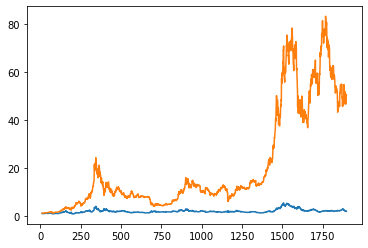

In [69]:
#визуализируем результаты
plt.plot(np.cumprod(1+data['strategy']))
plt.plot(np.cumprod(1+data['r']))
r_strat = np.prod(1+data['strategy'])**(256/len(data['strategy'])) - 1
r_bnh = np.prod(1+data['r'])**(256/len(data['r'])) - 1
print('Годовая доходность стратегии скользящих средних '+str(round(r_strat*100,2))+'%')
print('Годовая доходность стратегии buy and hold '+str(round(r_bnh*100,2))+'%')